# Link Prediction

We perform unsupervised and supervised link predictions task. Major implementation choices and specifics are described in comments in the blocks

### Import library and pre-processing

In [ ]:
from IPython.display import clear_output

In [ ]:
%env PYTHONPATH = # /env/python

env: PYTHONPATH=# /env/python


In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py38_4.12.0-Linux-x86_64.sh
!chmod +x Miniconda3-py38_4.12.0-Linux-x86_64.sh
!./Miniconda3-py38_4.12.0-Linux-x86_64.sh -b -f -p /usr/local
!conda update conda -y

clear_output()

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')

In [ ]:
!conda create -n myenv python=3.8 - y
clear_output()

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv

pip install linkpred
pip install stellargraph
pip install node2vec
pip uninstall pyOpenSSL -y

In [ ]:
#python version 3.8 required for compatibility with StellarGraph
!python --version

Python 3.8.17


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import linkpred
import node2vec

import random
import itertools
from linkpred.evaluation import Pair
import warnings

from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, f1_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, ParameterGrid,  GridSearchCV


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
with open("artists_graph_20.pickle", 'rb') as f:  # notice the r instead of w
    G = pickle.load(f)

In [ ]:
node_degrees = {node: val for (node, val) in G.degree()}
node_degrees
G_filtered = (G.subgraph([k for k, v in node_degrees.items() if v >= 40])).copy()
nx.is_frozen(G_filtered)

#adding .copy() is needed to avoid that the result of .subgraph() will be a frozen graph,
#from which we can't delete further nodes.

#we follow the guide in https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.freeze.html

False

In [ ]:
#we only keep nodes having a degree higher then 40

(len(G_filtered.nodes()), len(G_filtered.edges()))

(850, 2703)

In [ ]:
graph_components = sorted(nx.connected_components(G_filtered), key=len, reverse=True)

In [ ]:
del_nodes = []
for component in graph_components:
  if len(component) <= 5:
    for node in component:
      del_nodes.append(node)

len(del_nodes)

184

In [ ]:
G_filtered.remove_nodes_from(del_nodes)

In [ ]:
#we further filter out in terms of components size
(len(G_filtered.nodes()), len(G_filtered.edges()))

(666, 2582)

### Unsupervised link prediction

In [ ]:
H = G_filtered.copy()
test_size = int(len(H) * 0.3) #keep a 30% test set

In [ ]:
random.seed(42)
test = H.subgraph(random.sample(H.nodes(), test_size))
training = H.copy()
training.remove_edges_from(test.edges())

print("Training nodes: ", len(training.nodes()))
print("Training edges: ", len(training.edges()))

print("Test nodes: ", len(test.nodes()))
print("Test edges: ", len(test.edges()))



Training nodes:  666
Training edges:  2357
Test nodes:  199
Test edges:  225


<ipython-input-17-ac7816e94b1a>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test = H.subgraph(random.sample(H.nodes(), test_size))


In [ ]:
# Node set
nodes = list(H.nodes())
nodes.extend(list(test.nodes()))

In [ ]:
# Compute the test set and the universe set
test = [Pair(i) for i in test.edges()]
universe = set([Pair(i) for i in itertools.product(nodes, nodes) if i[0]!=i[1]])

In [ ]:
len(universe)

221445

In [ ]:
#perform unsupervised training and predictions with different methods

cn = linkpred.predictors.CommonNeighbours(training, excluded=training.edges())
cn_results = cn.predict()

aa = linkpred.predictors.AdamicAdar(training, excluded=training.edges())
aa_results = aa.predict()

jc = linkpred.predictors.Jaccard(training, excluded=training.edges())
jc_results = jc.predict()

simrank = linkpred.predictors.SimRank(training, excluded=training.edges())
simrank_results_03 = simrank.predict(c=0.3)
simrank_results_05 = simrank.predict(c=0.5)
simrank_results_07 = simrank.predict(c=0.7)

random = linkpred.predictors.Random(training, excluded=training.edges())
rnd_results = random.predict()

In [ ]:
print('\n CommonNeighbours \n')

top = cn_results.top(10)
for edge, score in top.items():
    print(edge, score, end = '\n')

print('\n AdamicAdar \n')

top = aa_results.top(10)
for edge, score in top.items():
    print(edge, score, end = '\n')

print('\n Jaccard \n')

top = jc_results.top(10)
for edge, score in top.items():
    print(edge, score, end = '\n')

print('\n SimRank_03 \n')

top = simrank_results_03.top(10)
for edge, score in top.items():
    print(edge, score, end = '\n')

print('\n SimRank_05 \n')

top = simrank_results_05.top(10)
for edge, score in top.items():
    print(edge, score, end = '\n')


print('\n SimRank_07 \n')

top = simrank_results_07.top(10)
for edge, score in top.items():
    print(edge, score, end = '\n')


print('\n Random \n')

top = rnd_results.top(10)
for edge, score in top.items():
    print(edge, score, end = '\n')


 CommonNeighbours 

Neeraj Shridhar - Anu Malik 20.0
Sviatoslav Richter - Mikhail Pletnev 19.0
Mikhail Pletnev - Dinu Lipatti 18.0
Sviatoslav Richter - Nelson Freire 17.0
Vishal Dadlani - Rekha Bhardwaj 16.0
Roop Kumar Rathod - Benny Dayal 16.0
Nelson Freire - Murray Perahia 16.0
Murray Perahia - Mikhail Pletnev 16.0
Vishal Dadlani - Shaan 15.0
Javed Ali - Anu Malik 15.0

 AdamicAdar 

Sentidos Opuestos - Paty Cantú 8.212593551369139
Neeraj Shridhar - Anu Malik 6.853027752139031
Sviatoslav Richter - Mikhail Pletnev 6.630917267210951
Mikhail Pletnev - Dinu Lipatti 6.211183451205195
Sviatoslav Richter - Nelson Freire 5.798549383366537
Murray Perahia - Mikhail Pletnev 5.433614137622257
Nelson Freire - Murray Perahia 5.414463917371048
Vishal Dadlani - Rekha Bhardwaj 5.391056197113636
Roop Kumar Rathod - Benny Dayal 5.156827382311581
Javed Ali - Anu Malik 5.066105711375186

 Jaccard 

neko - Dsippy 1.0
neko - DJ Davion 1.0
glexks - PHOROMANE 1.0
dopesmoke - WorkRate 1.0
dopesmoke - Izzpot 

In [ ]:
cn_evaluation = linkpred.evaluation.EvaluationSheet(cn_results, test, universe)

In [ ]:
aa_evaluation = linkpred.evaluation.EvaluationSheet(aa_results, test, universe)

In [ ]:
jc_evaluation = linkpred.evaluation.EvaluationSheet(jc_results, test, universe)

In [ ]:
rn_evaluation = linkpred.evaluation.EvaluationSheet(rnd_results, test, universe)

In [ ]:
simrank_evaluation_03 = linkpred.evaluation.EvaluationSheet(simrank_results_03, test, universe)
simrank_evaluation_05 = linkpred.evaluation.EvaluationSheet(simrank_results_05, test, universe)
simrank_evaluation_07 = linkpred.evaluation.EvaluationSheet(simrank_results_07, test, universe)

In [ ]:
evaluations_dict = {'CommonNeighbors' : cn_evaluation, 'AdamicAdar' : aa_evaluation,
                'Jaccard' : jc_evaluation, 'SimRank_03' :simrank_evaluation_03,
                'SimRank_05' : simrank_evaluation_05, 'SimRank_07' : simrank_evaluation_07,
                'Random' : rn_evaluation}

evaluations_dict_AUC = { method : auc(evaluation.fallout(), evaluation.recall()) for method, evaluation in evaluations_dict.items()}
evaluations_dict_AUC_PR = { method : auc(evaluation.recall(), evaluation.precision()) for method, evaluation in evaluations_dict.items()}

(evaluations_dict_AUC,evaluations_dict_AUC_PR)

({'CommonNeighbors': 0.006226139890907995,
  'AdamicAdar': 0.006803101989974787,
  'Jaccard': 0.008460034756752957,
  'SimRank_03': 0.9867957488272107,
  'SimRank_05': 0.9863949612753519,
  'SimRank_07': 0.9849662779133895,
  'Random': 0.5245157870513031},
 {'CommonNeighbors': 0.15478582550811343,
  'AdamicAdar': 0.18966353317942145,
  'Jaccard': 0.5518421923906819,
  'SimRank_03': 0.4074138643925478,
  'SimRank_05': 0.4000182748912516,
  'SimRank_07': 0.3802118685654221,
  'Random': 0.001220311253044093})

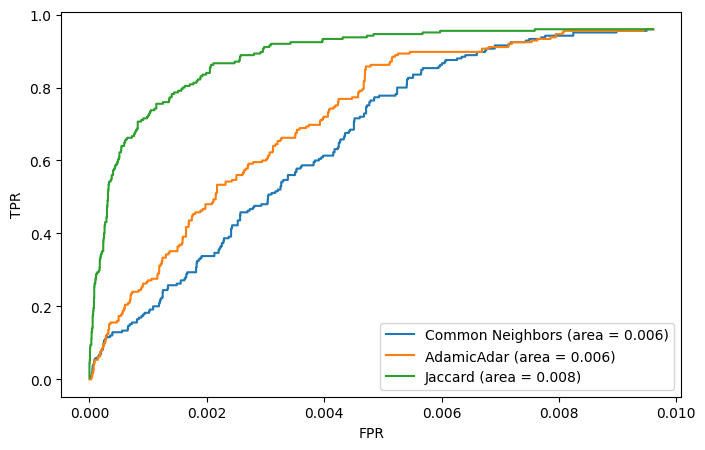

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(cn_evaluation.fallout(), cn_evaluation.recall(), label="Common Neighbors " "(area = " + str(evaluations_dict_AUC["CommonNeighbors"])[:5] + ")")
plt.plot(aa_evaluation.fallout(), aa_evaluation.recall(), label="AdamicAdar " "(area = " + str(evaluations_dict_AUC["AdamicAdar"])[:5] + ")")
plt.plot(jc_evaluation.fallout(), jc_evaluation.recall(), label="Jaccard " "(area = " + str(evaluations_dict_AUC["Jaccard"])[:5] + ")")


plt.xlabel('FPR', fontsize=10)
plt.ylabel('TPR', fontsize = 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(loc = "lower right")
plt.show()


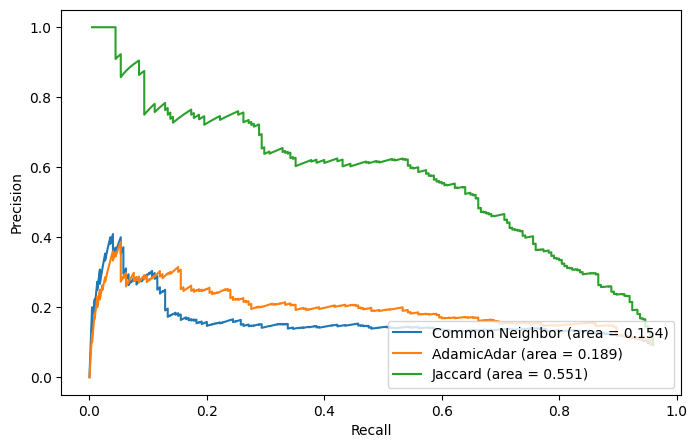

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(cn_evaluation.recall(), cn_evaluation.precision(), label = "Common Neighbor " "(area = " + str(evaluations_dict_AUC_PR["CommonNeighbors"])[:5] + ")")
plt.plot(aa_evaluation.recall(), aa_evaluation.precision(), label = "AdamicAdar " "(area = " + str(evaluations_dict_AUC_PR["AdamicAdar"])[:5] + ")")
plt.plot(jc_evaluation.recall(), jc_evaluation.precision(), label = "Jaccard " "(area = " + str(evaluations_dict_AUC_PR["Jaccard"])[:5] + ")")


plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize = 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(loc = "lower right")
plt.show()

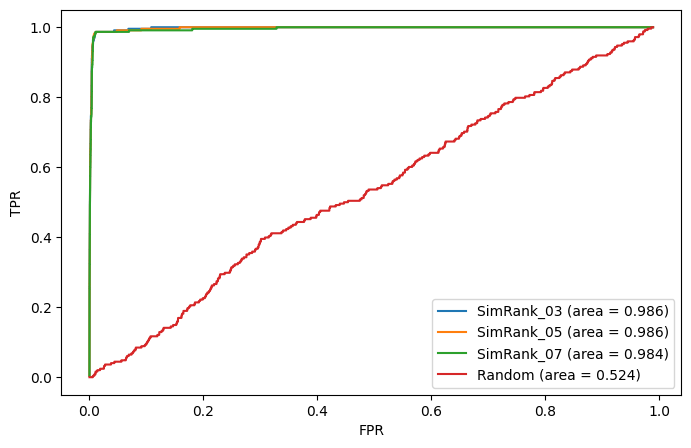

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(simrank_evaluation_03.fallout(), simrank_evaluation_03.recall(), label="SimRank_03 " "(area = " + str(evaluations_dict_AUC["SimRank_03"])[:5] + ")")
plt.plot(simrank_evaluation_05.fallout(), simrank_evaluation_05.recall(), label="SimRank_05 " "(area = " + str(evaluations_dict_AUC["SimRank_05"])[:5] + ")")
plt.plot(simrank_evaluation_07.fallout(), simrank_evaluation_07.recall(), label="SimRank_07 " "(area = " + str(evaluations_dict_AUC["SimRank_07"])[:5] + ")")
plt.plot(rn_evaluation.fallout(), rn_evaluation.recall(), label="Random " "(area = " + str(evaluations_dict_AUC["Random"])[:5] + ")")



plt.xlabel('FPR', fontsize=10)
plt.ylabel('TPR', fontsize = 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(loc = "lower right")
plt.show()


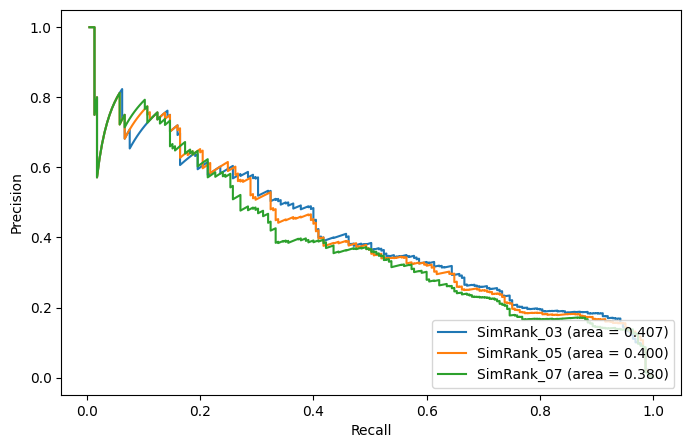

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(simrank_evaluation_03.recall(), simrank_evaluation_03.precision(), label = "SimRank_03 " "(area = " + str(evaluations_dict_AUC_PR["SimRank_03"])[:5] + ")")
plt.plot(simrank_evaluation_05.recall(), simrank_evaluation_05.precision(), label = "SimRank_05 " "(area = " + str(evaluations_dict_AUC_PR["SimRank_05"])[:5] + ")")
plt.plot(simrank_evaluation_07.recall(), simrank_evaluation_07.precision(), label = "SimRank_07 " "(area = " + str(evaluations_dict_AUC_PR["SimRank_07"])[:5] + ")")

plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize = 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(loc = "lower right")
plt.show()

In [ ]:
#check interesections for top 250 results

results_dict = {'CommonNeighbours' : cn_results.top(250), 'AdamicAdar ' : aa_results.top(250),
                'Jaccard ' : jc_results.top(250), 'SimRank_03' :simrank_results_03.top(250),
                'SimRank_05' : simrank_results_05.top(250), 'SimRank_07' : simrank_results_07.top(250),
                'Random' : rnd_results.top(250)}

results_intersect = {}

results_intersect_counts = {}

for method, result in results_dict.items():

  for method_, result_  in results_dict.items():

    curr_intersection = set(result) & set(result_)
    results_intersect[method + ' WITH ' + method_] = tuple(curr_intersection)
    results_intersect_counts[method + ' WITH ' + method_] = len(curr_intersection)



In [ ]:
results_intersect_counts

{'CommonNeighbours WITH CommonNeighbours': 250,
 'CommonNeighbours WITH AdamicAdar ': 205,
 'CommonNeighbours WITH Jaccard ': 59,
 'CommonNeighbours WITH SimRank_03': 0,
 'CommonNeighbours WITH SimRank_05': 0,
 'CommonNeighbours WITH SimRank_07': 0,
 'CommonNeighbours WITH Random': 0,
 'AdamicAdar  WITH CommonNeighbours': 205,
 'AdamicAdar  WITH AdamicAdar ': 250,
 'AdamicAdar  WITH Jaccard ': 93,
 'AdamicAdar  WITH SimRank_03': 4,
 'AdamicAdar  WITH SimRank_05': 7,
 'AdamicAdar  WITH SimRank_07': 7,
 'AdamicAdar  WITH Random': 0,
 'Jaccard  WITH CommonNeighbours': 59,
 'Jaccard  WITH AdamicAdar ': 93,
 'Jaccard  WITH Jaccard ': 250,
 'Jaccard  WITH SimRank_03': 127,
 'Jaccard  WITH SimRank_05': 125,
 'Jaccard  WITH SimRank_07': 130,
 'Jaccard  WITH Random': 0,
 'SimRank_03 WITH CommonNeighbours': 0,
 'SimRank_03 WITH AdamicAdar ': 4,
 'SimRank_03 WITH Jaccard ': 127,
 'SimRank_03 WITH SimRank_03': 250,
 'SimRank_03 WITH SimRank_05': 241,
 'SimRank_03 WITH SimRank_07': 231,
 'SimRank_0

### Supervised Link Prediction

In [ ]:
G

In [ ]:
edge_splitter_test  = EdgeSplitter(G)

In [ ]:
#generate graph_test
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

** Sampled 37371 positive and 37371 negative edges. **


In [ ]:
#generate graph_train

edge_splitter_train = EdgeSplitter(graph_test, G)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

** Sampled 33634 positive and 33634 negative edges. **


In [ ]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,50451,Train Graph,Test Graph,Train the Link Classifier
Model Selection,16817,Train Graph,Test Graph,Select the best Link Classifier model
Test set,74742,Test Graph,Full Graph,Evaluate the best Link Classifier


In [ ]:
#import node2vec and binary operators on node emebeddings
from node2vec import Node2Vec
from node2vec.edges import AverageEmbedder, HadamardEmbedder, WeightedL1Embedder, WeightedL2Embedder

In [ ]:
node2vec = Node2Vec(graph_train)

Computing transition probabilities:   0%|          | 0/63717 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [08:36<00:00, 51.61s/it]


In [ ]:
model = node2vec.fit()

In [ ]:
model

In [ ]:
keyed_vectors=model.wv

In [ ]:
hadamard_embeds = HadamardEmbedder(keyed_vectors)
avg_embeds = AverageEmbedder(keyed_vectors)
L1_embeds = WeightedL1Embedder(keyed_vectors)
L2_embeds = WeightedL2Embedder(keyed_vectors)

In [ ]:
train_embeddings_hadamard = [hadamard_embeds[str(x[0]),str(x[1])] for x in examples_train]
test_embeddings_hadamard = [hadamard_embeds[str(x[0]),str(x[1])] for x in examples_test]

In [ ]:
train_embeddings_avg = [avg_embeds[str(x[0]),str(x[1])] for x in examples_train]
test_embeddings_avg = [avg_embeds[str(x[0]),str(x[1])] for x in examples_test]

In [ ]:
train_embeddings_l1 = [L1_embeds[str(x[0]),str(x[1])] for x in examples_train]
test_embeddings_l1 = [L1_embeds[str(x[0]),str(x[1])] for x in examples_test]

In [ ]:
train_embeddings_l2 = [L2_embeds[str(x[0]),str(x[1])] for x in examples_train]
test_embeddings_l2 = [L2_embeds[str(x[0]),str(x[1])] for x in examples_test]

In [ ]:
skf = StratifiedKFold(shuffle=True, random_state = 42)

In [ ]:
#define a function to perform gridsearch over a generic hyperparameter space

def perform_gridsearch(classifier, param_grid, cv, X_train, y_train, X_test, y_test, scoring = None):

  clf = GridSearchCV(estimator = classifier, param_grid = param_grid, n_jobs = -1, cv = cv, scoring = scoring)
  clf.fit(X_train, y_train)

  best_model = clf.best_estimator_

  predictions = best_model.predict(X_test)

  print('Best configuration', clf.best_params_)
  print('Best mean score for the validation', clf.best_score_)
  print('Std for the best mean score across folds',clf.cv_results_['std_test_score'][clf.best_index_])

  print('******************')

  print('Classification report:')
  print(classification_report(y_test, predictions, digits = 7))
  print('Confusion matrix:')
  cm = confusion_matrix(y_test, predictions)
  print(cm)

  print('******************')

  y_score = best_model.predict_proba(X_test)

  fpr, tpr, th = roc_curve(y_test, y_score[:,1])

  roc_auc = auc(fpr, tpr)
  print('ROC_AUC value: ', roc_auc)

  print('******************')

  print(clf.cv_results_['mean_test_score'])

  return best_model, fpr, tpr


In [ ]:
parameters_logistic = {'penalty': ('none', 'l2', 'l1'), 'C':[1.0,0.1,0.001],
                       'solver' : [ 'lbfgs','newton-cg','liblinear']}

parameters_dt = {'min_samples_split': [2,4,6,8,10], 'min_samples_leaf':[1,2,3,5,8,10],
                 'criterion': ['gini','entropy']}


parameters_knn = {'n_neighbors': [3,5,7,9,11],
                 'weights': ['uniform','distance']}


#### Logistic Regression

In [ ]:
#HadamardEmbedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(LogisticRegression(), parameters_logistic, skf, train_embeddings_hadamard, labels_train, test_embeddings_hadamard, labels_test)

Best configuration {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
Best mean score for the validation 0.9689599667800028
Std for the best mean score across folds 0.0013082540480924573
******************
Classification report:
              precision    recall  f1-score   support

           0  0.9485198 0.9919724 0.9697596     37371
           1  0.9915870 0.9461615 0.9683418     37371

    accuracy                      0.9690669     74742
   macro avg  0.9700534 0.9690669 0.9690507     74742
weighted avg  0.9700534 0.9690669 0.9690507     74742

Confusion matrix:
[[37071   300]
 [ 2012 35359]]
******************
ROC_AUC value:  0.9530030124245888
******************
[0.95722579 0.95722579        nan 0.95831596 0.95831596 0.95829614
        nan        nan 0.9577015  0.95722579 0.95722579        nan
 0.96198292 0.96198292 0.96190363        nan        nan 0.96087291
 0.95722579 0.95722579        nan 0.96895997 0.96895997 0.96652198
        nan        nan 0.75689279]


In [ ]:
#AverageEmbedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(LogisticRegression(), parameters_logistic, skf, train_embeddings_avg, labels_train, test_embeddings_avg, labels_test)


Best configuration {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Best mean score for the validation 0.6587975370609123
Std for the best mean score across folds 0.003963252532211631
******************
Classification report:
              precision    recall  f1-score   support

           0  0.6967094 0.5880763 0.6378002     37371
           1  0.6436409 0.7439994 0.6901910     37371

    accuracy                      0.6660378     74742
   macro avg  0.6701751 0.6660378 0.6639956     74742
weighted avg  0.6701751 0.6660378 0.6639956     74742

Confusion matrix:
[[21977 15394]
 [ 9567 27804]]
******************
ROC_AUC value:  0.7199462072392571
******************
[0.65869843 0.65871826        nan 0.6587579  0.65879754 0.65816326
        nan        nan 0.65842092 0.65869843 0.65871826        nan
 0.65857949 0.65852003 0.65298993        nan        nan 0.65687487
 0.65869843 0.65871826        nan 0.65298985 0.65308895 0.5846662
        nan        nan 0.501219  ]


In [ ]:
#WeightedL1Embedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(LogisticRegression(), parameters_logistic, skf, train_embeddings_l1, labels_train, test_embeddings_l1, labels_test)


Best configuration {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
Best mean score for the validation 0.9442231000177866
Std for the best mean score across folds 0.0014907267132531102
******************
Classification report:
              precision    recall  f1-score   support

           0  0.9225119 0.9713147 0.9462845     37371
           1  0.9697124 0.9184127 0.9433656     37371

    accuracy                      0.9448637     74742
   macro avg  0.9461122 0.9448637 0.9448251     74742
weighted avg  0.9461122 0.9448637 0.9448251     74742

Confusion matrix:
[[36299  1072]
 [ 3049 34322]]
******************
ROC_AUC value:  0.971080905245086
******************
[0.93702799 0.93702799        nan 0.93706763 0.93706763 0.93704781
        nan        nan 0.93716674 0.93702799 0.93702799        nan
 0.93764245 0.93764245 0.93805869        nan        nan 0.93791995
 0.93702799 0.93702799        nan 0.9442231  0.9442231  0.92162693
        nan        nan 0.9274742 ]


In [ ]:
#WeightedL2Embedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(LogisticRegression(), parameters_logistic, skf, train_embeddings_l2, labels_train, test_embeddings_l2, labels_test)


Best configuration {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
Best mean score for the validation 0.943152754925225
Std for the best mean score across folds 0.0017311930042183553
******************
Classification report:
              precision    recall  f1-score   support

           0  0.9303308 0.9601295 0.9449953     37371
           1  0.9588102 0.9280993 0.9432048     37371

    accuracy                      0.9441144     74742
   macro avg  0.9445705 0.9441144 0.9441001     74742
weighted avg  0.9445705 0.9441144 0.9441001     74742

Confusion matrix:
[[35881  1490]
 [ 2687 34684]]
******************
ROC_AUC value:  0.9719188531216476
******************
[0.93502606 0.93502606        nan 0.93510535 0.93512517 0.93508553
        nan        nan 0.93508553 0.93502606 0.93502606        nan
 0.93564052 0.93566034 0.93573963        nan        nan 0.9358982
 0.93502606 0.93502606        nan 0.94315275 0.94315275 0.94180492
        nan        nan 0.93078431]


#### Decision Tree Classifier

In [ ]:
#HadamardEmbedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(DecisionTreeClassifier(), parameters_dt, skf, train_embeddings_hadamard, labels_train, test_embeddings_hadamard, labels_test)


Best configuration {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 8}
Best mean score for the validation 0.8857703323934555
Std for the best mean score across folds 0.0020375728509441807
******************
Classification report:
              precision    recall  f1-score   support

           0  0.8831062 0.8913061 0.8871872     37371
           1  0.8902874 0.8820208 0.8861348     37371

    accuracy                      0.8866635     74742
   macro avg  0.8866968 0.8866635 0.8866610     74742
weighted avg  0.8866968 0.8866635 0.8866610     74742

Confusion matrix:
[[33309  4062]
 [ 4409 32962]]
******************
ROC_AUC value:  0.9014980900920343
******************
[0.8854136  0.88553247 0.88440268 0.88436305 0.8845415  0.88374852
 0.8851162  0.88362964 0.88577033 0.88374862 0.8829359  0.88317379
 0.88418462 0.88481891 0.88355039 0.88297555 0.88249988 0.88194487
 0.8826188  0.88240075 0.87831763 0.87857535 0.87913033 0.87841674
 0.87833749 0.87667241 0.87631565 0.

In [ ]:
#AverageEmbedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(DecisionTreeClassifier(), parameters_dt, skf, train_embeddings_avg, labels_train, test_embeddings_avg, labels_test)


Best configuration {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best mean score for the validation 0.8348695336265554
Std for the best mean score across folds 0.002539621664613807
******************
Classification report:
              precision    recall  f1-score   support

           0  0.8538900 0.8328918 0.8432602     37371
           1  0.8369026 0.8574831 0.8470678     37371

    accuracy                      0.8451874     74742
   macro avg  0.8453963 0.8451874 0.8451640     74742
weighted avg  0.8453963 0.8451874 0.8451640     74742

Confusion matrix:
[[31126  6245]
 [ 5326 32045]]
******************
ROC_AUC value:  0.8451874448101468
******************
[0.81960718 0.8204     0.81825932 0.81857657 0.81679256 0.81528615
 0.81693129 0.81659443 0.81699072 0.81637634 0.82101451 0.82053883
 0.82067757 0.82071718 0.81982526 0.82152989 0.82141094 0.82147037
 0.82123255 0.82125236 0.82039999 0.8214307  0.82180729 0.82028104
 0.82073693 0.82012248 0.81944857 

In [ ]:
#WeightedL1Embedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(DecisionTreeClassifier(), parameters_dt, skf, train_embeddings_l1, labels_train, test_embeddings_l1, labels_test)


Best configuration {'criterion': 'entropy', 'min_samples_leaf': 10, 'min_samples_split': 4}
Best mean score for the validation 0.8660085196957439
Std for the best mean score across folds 0.003308759244737846
******************
Classification report:
              precision    recall  f1-score   support

           0  0.8695826 0.8708624 0.8702221     37371
           1  0.8706721 0.8693907 0.8700309     37371

    accuracy                      0.8701266     74742
   macro avg  0.8701274 0.8701266 0.8701265     74742
weighted avg  0.8701274 0.8701266 0.8701265     74742

Confusion matrix:
[[32545  4826]
 [ 4881 32490]]
******************
ROC_AUC value:  0.9127740547603636
******************
[0.85086516 0.85161835 0.85229232 0.85213374 0.85528532 0.8587936
 0.85657363 0.85811969 0.85909096 0.85891256 0.85373918 0.85449238
 0.85385811 0.85613759 0.85863506 0.85821887 0.8590117  0.85734674
 0.85932884 0.8595667  0.86434358 0.86382822 0.86364983 0.86372915
 0.86359038 0.86404625 0.86448231 

In [ ]:
#WeightedL2Embedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(DecisionTreeClassifier(), parameters_dt, skf, train_embeddings_l2, labels_train, test_embeddings_l2, labels_test)


Best configuration {'criterion': 'entropy', 'min_samples_leaf': 10, 'min_samples_split': 6}
Best mean score for the validation 0.8654931854514404
Std for the best mean score across folds 0.002373435875220154
******************
Classification report:
              precision    recall  f1-score   support

           0  0.8702070 0.8708357 0.8705212     37371
           1  0.8707423 0.8701132 0.8704276     37371

    accuracy                      0.8704744     74742
   macro avg  0.8704746 0.8704744 0.8704744     74742
weighted avg  0.8704746 0.8704744 0.8704744     74742

Confusion matrix:
[[32544  4827]
 [ 4854 32517]]
******************
ROC_AUC value:  0.9124432930785384
******************
[0.85064712 0.85153902 0.85183637 0.85352115 0.85358066 0.8582783
 0.85752505 0.85833779 0.85875395 0.85815938 0.85344187 0.85451229
 0.85326346 0.85643487 0.85718814 0.85871438 0.85695032 0.8577828
 0.85716834 0.85770346 0.86335253 0.8639868  0.86345162 0.86327322
 0.86388767 0.8633525  0.86339213 0

#### K-nearest neighbors

In [ ]:
#HadamardEmbedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(KNeighborsClassifier(), parameters_knn, skf, train_embeddings_hadamard, labels_train, test_embeddings_hadamard, labels_test)


Best configuration {'n_neighbors': 3, 'weights': 'distance'}
Best mean score for the validation 0.9675328386803969
Std for the best mean score across folds 0.0011122047694969227
******************
Classification report:
              precision    recall  f1-score   support

           0  0.9493615 0.9867812 0.9677098     37371
           1  0.9862388 0.9473656 0.9664114     37371

    accuracy                      0.9670734     74742
   macro avg  0.9678002 0.9670734 0.9670606     74742
weighted avg  0.9678002 0.9670734 0.9670606     74742

Confusion matrix:
[[36877   494]
 [ 1967 35404]]
******************
ROC_AUC value:  0.9711706043355876
******************
[0.96650214 0.96753284 0.96664088 0.96703731 0.96638321 0.96660124
 0.96608589 0.96634356 0.96600661 0.96612554]


In [ ]:
#AverageEmbedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(KNeighborsClassifier(), parameters_knn, skf, train_embeddings_avg, labels_train, test_embeddings_avg, labels_test)


Best configuration {'n_neighbors': 11, 'weights': 'distance'}
Best mean score for the validation 0.9547085270323505
Std for the best mean score across folds 0.002446219030175797
******************
Classification report:
              precision    recall  f1-score   support

           0  0.9560845 0.9565706 0.9563275     37371
           1  0.9565485 0.9560622 0.9563053     37371

    accuracy                      0.9563164     74742
   macro avg  0.9563165 0.9563164 0.9563164     74742
weighted avg  0.9563165 0.9563164 0.9563164     74742

Confusion matrix:
[[35748  1623]
 [ 1642 35729]]
******************
ROC_AUC value:  0.9813045547936228
******************
[0.92791026 0.92991219 0.94015977 0.94279598 0.94537275 0.9488811
 0.94898021 0.95332103 0.95007038 0.95470853]


In [ ]:
#WeightedL1Embedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(KNeighborsClassifier(), parameters_knn, skf, train_embeddings_l1, labels_train, test_embeddings_l1, labels_test)


Best configuration {'n_neighbors': 3, 'weights': 'distance'}
Best mean score for the validation 0.8668609135558194
Std for the best mean score across folds 0.0018152309065120388
******************
Classification report:
              precision    recall  f1-score   support

           0  0.9553427 0.7899708 0.8648221     37371
           1  0.8209626 0.9630730 0.8863578     37371

    accuracy                      0.8765219     74742
   macro avg  0.8881526 0.8765219 0.8755899     74742
weighted avg  0.8881526 0.8765219 0.8755899     74742

Confusion matrix:
[[29522  7849]
 [ 1380 35991]]
******************
ROC_AUC value:  0.9427971110848143
******************
[0.86509683 0.86686091 0.85827835 0.86063707 0.85106337 0.85369959
 0.84311507 0.8463063  0.83701017 0.84065728]


In [ ]:
#WeightedL2Embedder

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    perform_gridsearch(KNeighborsClassifier(), parameters_knn, skf, train_embeddings_l2, labels_train, test_embeddings_l2, labels_test)


Best configuration {'n_neighbors': 3, 'weights': 'distance'}
Best mean score for the validation 0.8522130200900252
Std for the best mean score across folds 0.0034711925764662295
******************
Classification report:
              precision    recall  f1-score   support

           0  0.9539599 0.7629178 0.8478099     37371
           1  0.8024746 0.9631800 0.8755138     37371

    accuracy                      0.8630489     74742
   macro avg  0.8782173 0.8630489 0.8616619     74742
weighted avg  0.8782173 0.8630489 0.8616619     74742

Confusion matrix:
[[28511  8860]
 [ 1376 35995]]
******************
ROC_AUC value:  0.9305878313645155
******************
[0.85058769 0.85221302 0.84012211 0.84236189 0.83066734 0.83399729
 0.82244157 0.82642563 0.81449324 0.81915123]


####  Supervised methods ROC-CURVE visualization

In [ ]:
best_LR = {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
best_KNN = {'n_neighbors': 3, 'weights': 'distance'}
best_DT = {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 8}

train_embeddings_hadamard, labels_train
test_embeddings_hadamard, labels_test



clf_LR = LogisticRegression(C = 0.001, penalty = 'l2', solver = 'lbfgs').fit(train_embeddings_hadamard, labels_train)
clf_DT = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 2, min_samples_split = 8).fit(train_embeddings_hadamard, labels_train)
clf_KNN = KNeighborsClassifier(n_neighbors=3, weights = 'distance').fit(train_embeddings_hadamard, labels_train)

predictions_LR = clf_LR.predict(test_embeddings_hadamard)
predictions_DT = clf_DT.predict(test_embeddings_hadamard)
predictions_KNN = clf_KNN.predict(test_embeddings_hadamard)

In [ ]:
y_score_LR = clf_LR.predict_proba(test_embeddings_hadamard)
fpr_LR, tpr_LR, th_LR = roc_curve(labels_test, y_score_LR[:,1])
roc_auc_LR = auc(fpr_LR, tpr_LR)

precision_LR, recall_LR, thr_LR = precision_recall_curve(labels_test, y_score_LR[:,1])

y_score_DT = clf_DT.predict_proba(test_embeddings_hadamard)
fpr_DT, tpr_DT, th_DT = roc_curve(labels_test, y_score_DT[:,1])
roc_auc_DT = auc(fpr_DT, tpr_DT)
roc_auc_DT

precision_DT, recall_DT, thr_DT = precision_recall_curve(labels_test, y_score_DT[:,1])

y_score_KNN = clf_KNN.predict_proba(test_embeddings_hadamard)
fpr_KNN, tpr_KNN, th_KNN = roc_curve(labels_test, y_score_KNN[:,1])
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
roc_auc_KNN

precision_KNN, recall_KNN, thr_KNN = precision_recall_curve(labels_test, y_score_KNN[:,1])

AUC_RESULTS = {'Logistic Regression': roc_auc_LR, 'Decision Tree' : roc_auc_DT, 'K-Nearest Neighbors' : roc_auc_KNN}
AUC_RESULTS

{'Logistic Regression': 0.9525529080551043,
 'Decision Tree': 0.9042669327418665,
 'K-Nearest Neighbors': 0.9714935319450332}

In [ ]:
AUC_RESULTS_PR = {'Logistic Regression': auc(recall_LR,precision_LR), 'Decision Tree' : auc(recall_DT,precision_DT), 'K-Nearest Neighbors' :auc(recall_KNN,precision_KNN)}
AUC_RESULTS_PR

{'Logistic Regression': 0.9746405033159973,
 'Decision Tree': 0.9260813862452326,
 'K-Nearest Neighbors': 0.9835015399493566}

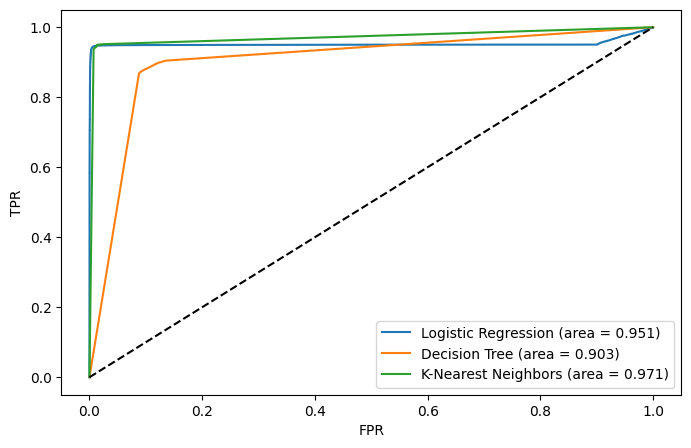

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(fpr_LR, tpr_LR, label = "Logistic Regression " + "(area = " + str(AUC_RESULTS["Logistic Regression"])[:5] + ")")
plt.plot(fpr_DT, tpr_DT, label = "Decision Tree " + "(area = " + str(AUC_RESULTS["Decision Tree"])[:5] + ")")
plt.plot(fpr_KNN, tpr_KNN, label = "K-Nearest Neighbors " + "(area = " + str(AUC_RESULTS["K-Nearest Neighbors"])[:5] + ")")
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('FPR', fontsize=10)
plt.ylabel('TPR', fontsize = 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(loc = "lower right")
plt.show()

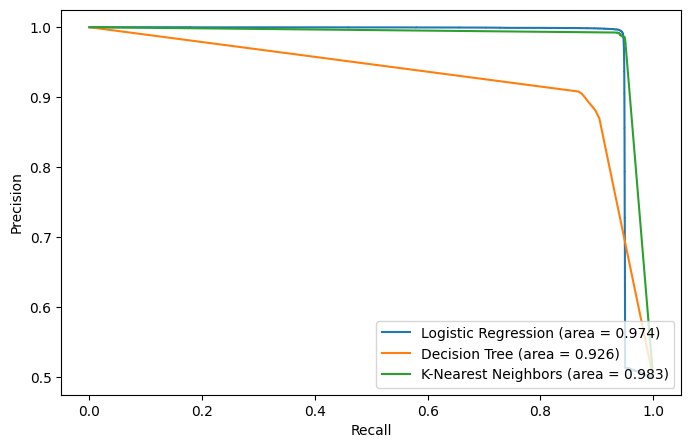

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(recall_LR, precision_LR, label = "Logistic Regression "+ "(area = " + str(AUC_RESULTS_PR["Logistic Regression"])[:5] + ")")
plt.plot(recall_DT, precision_DT, label = "Decision Tree "+ "(area = " + str(AUC_RESULTS_PR["Decision Tree"])[:5] + ")")
plt.plot(recall_KNN, precision_KNN, label = "K-Nearest Neighbors " + "(area = " + str(AUC_RESULTS_PR["K-Nearest Neighbors"])[:5] + ")")


plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize = 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(loc = "lower right")
plt.show()